## Import Required Libraries

We'll import all necessary Python libraries for financial data analysis, portfolio optimization, and visualization.

In [1]:
import warnings
import os
#from datetime import datetime, timedelta
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyoff
import yfinance as yf
#from plotly.subplots import make_subplots
from IPython.display import display, Markdown

from Backtester.BacktestResults import TestResults

warnings.filterwarnings('ignore')

## Load backtest data

In [2]:
universe_name = "selection3"; test_name = "GEM_LP"; index_name = "URTH" #"SPY"#

test_path = f"data/{universe_name}/{test_name}"
test_results = TestResults(test_path)
strategies_list = test_results.list_strategies()
lookback_periods = test_results.test_settings.get('lookback_periods', 0)
test_images_path = os.path.join(test_path, "images",test_name)
os.makedirs(test_images_path, exist_ok=True)

md = f"""
### Backtest Settings

- Test path: `{test_path}`
- Number of strategies: **{len(strategies_list)}**

```json
{json.dumps(test_results.test_settings, indent=2)}
```
### Strategies
```json
{json.dumps(strategies_list, indent=2)}
```
"""
display(Markdown(md))


### Backtest Settings

- Test path: `data/selection3/GEM_LP`
- Number of strategies: **11**

```json
{
  "universe_name": "selection3",
  "backtest_duration": 504,
  "lookback_periods": 127,
  "num_datasets": 100,
  "random_seed": 12,
  "num_assets": null,
  "test_name": "GEM_LP",
  "test_folder_path": "c:\\my-git\\DataScience-novaIMS\\APPM-individual\\data\\selection3\\GEM_LP"
}
```
### Strategies
```json
[
  "AAA1_noComission",
  "AAA1",
  "AAA2_noComission",
  "AAA2",
  "AAA_M1",
  "EqualWeight",
  "GEM1",
  "GEM3",
  "GEM5_noComission",
  "GEM5",
  "GEM_M1"
]
```


In [3]:
analyze_strategy = "AAA2_noComission"
analyze_by = "VWR"
index_name = "URTH" #"SPY"#

strategy_images_path = os.path.join(test_images_path, analyze_strategy)
os.makedirs(strategy_images_path, exist_ok=True)

index_data = yf.download(index_name, period="15y")['Close']
index_returns = np.log(index_data/index_data.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


In [4]:
strategies_avg_bt_performance = test_results.get_strategies_bt_performance(aggregator='mean') #possible values: 'mean', 'median', 'min', 'max'
strategies_bt_min_performance = test_results.get_strategies_bt_performance(aggregator='min')
strategies_bt_max_performance = test_results.get_strategies_bt_performance(aggregator='max')

columns_to_drop = ['Calmar ratio', 'SQN', 'SQN trades', 'period_avg', 'period_stddev', 'period_positive', 'period_negative', 'period_best', 'period_worst']
column_orders = ['VWR','Sharpe ratio', 'annual volatility', 'annual return', 'final_value', 'Sortino ratio', 'max drawdown', 'VaR (5%)', 'skewness', 'kurtosis']
strategies_avg_bt_performance = strategies_avg_bt_performance.drop(columns=columns_to_drop)
strategies_bt_min_performance = strategies_bt_min_performance.drop(columns=columns_to_drop)
strategies_bt_max_performance = strategies_bt_max_performance.drop(columns=columns_to_drop)
strategies_avg_bt_performance = strategies_avg_bt_performance[column_orders]
strategies_bt_min_performance = strategies_bt_min_performance[column_orders]
strategies_bt_max_performance = strategies_bt_max_performance[column_orders]

strategy_summary_df = pd.DataFrame({
    "Average": strategies_avg_bt_performance.loc[analyze_strategy],
    "Minimum": strategies_bt_min_performance.loc[analyze_strategy],
    "Maximum": strategies_bt_max_performance.loc[analyze_strategy],
}).T

def format_df(df, decimals=2):
    return df.applymap(lambda x: f"{x:,.{decimals}f}" if isinstance(x, (int, float, np.floating)) else x)

display(Markdown(f"#### {analyze_strategy} Performance"))
display(Markdown(format_df(strategy_summary_df).sort_values('VWR').to_markdown()))

#of not existing, create images directory
if not os.path.exists("images"):
    os.makedirs("images")
if not os.path.exists(f"images/{analyze_strategy}"):
    os.makedirs(f"images/{analyze_strategy}")

with open(f"{strategy_images_path}/performance_analyzers.md", "w") as f:
    f.write(f"#### {analyze_strategy} Performance\n")
    f.write(format_df(strategy_summary_df).sort_values('VWR').to_markdown())

strategy_returns = test_results.strategies[analyze_strategy].get_returns()
strategy_cum_returns = (1 + strategy_returns).cumprod()
datasets_returns = test_results.strategies[analyze_strategy].get_datasets_returns()
datasets_cum_returns = (1 + datasets_returns).cumprod()

# Build an interactive Plotly chart showing all dataset cum-returns (faint gray)
# with the strategy cumulative return overlaid in blue.
# Use existing variables: datasets_cum_returns, strategy_cum_returns, analyze_strategy

# Prepare strategy series (handle DataFrame or Series)
if isinstance(strategy_cum_returns, pd.DataFrame):
    strat_series = strategy_cum_returns.iloc[:, 0]
else:
    strat_series = strategy_cum_returns

fig = go.Figure(layout=dict(height=700))

# Add each dataset as a faint gray trace
for col in datasets_cum_returns.columns:
    fig.add_trace(go.Scatter(
        x=datasets_cum_returns.index,
        y=datasets_cum_returns[col],
        mode='lines',
        line=dict(color='gray', width=1),
        opacity=0.7,
        name=col,
        showlegend=False,
        hovertemplate=col + '<br>Date: %{x}<br>Cumulative Return: %{y:.4f}<extra></extra>'
    ))

# Add the strategy cumulative return on top
fig.add_trace(go.Scatter(
    x=strat_series.index,
    y=strat_series.values,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'{analyze_strategy} (Average)',
    hovertemplate=analyze_strategy + '<br>Date: %{x}<br>Cumulative Return: %{y:.4f}<extra></extra>'
))

fig.update_layout(
    title=f'Cumulative Returns of Strategy: {analyze_strategy}',
    xaxis_title='Date',
    yaxis_title='Cumulative Return',
    hovermode='closest',   # show only one data point on hover
    showlegend=False
)

pyoff.iplot(fig)

#### AAA2_noComission Performance

|         |   VWR |   Sharpe ratio |   annual volatility |   annual return | final_value   |   Sortino ratio |   max drawdown |   VaR (5%) |   skewness |   kurtosis |
|:--------|------:|---------------:|--------------------:|----------------:|:--------------|----------------:|---------------:|-----------:|-----------:|-----------:|
| Minimum | -7.35 |          -4.93 |                0.08 |           -0.18 | 67,684.18     |           -1.67 |           0.08 |      -0.02 |      -1.64 |       0.58 |
| Average |  0.98 |          -0.03 |                0.11 |            0.02 | 104,488.08    |            0.16 |           0.16 |      -0.01 |      -0.57 |       3.51 |
| Maximum | 10.52 |           4.36 |                0.16 |            0.23 | 151,957.47    |            2.01 |           0.35 |      -0.01 |       0.3  |       9.15 |

In [5]:
#prepare datasets stats dataframe

def calculate_index_final_value(index_returns, start_date, end_date,starting_value=100000):
    # Filter index returns for the given date range
    filtered_returns = index_returns[(index_returns.index >= start_date) & (index_returns.index <= end_date)]
    # Calculate cumulative return
    cumulative_return = (1 + filtered_returns).prod()
    final_value = starting_value * cumulative_return
    return final_value.round(2)

datasets_stats = test_results.strategies[analyze_strategy].get_datasets_bt_performance().sort_values(by=analyze_by, ascending=False)
datasets_stats = datasets_stats.drop(columns=columns_to_drop)
datasets_list = test_results.strategies[analyze_strategy].datasets.keys()
datasets_info = test_results.datasets

#datasets_top_data = test_results.get_datasets_data(datasets_filter_list=top_list,column="adjusted")
datasets_adjusted = test_results.get_datasets_data(column="adjusted")

for i, ds in enumerate(datasets_adjusted.keys()):
    datasets_stats.loc[ds, 'Start Date'] = datasets_adjusted[ds].index.min()
    datasets_stats.loc[ds, 'End Date'] = datasets_adjusted[ds].index.max()

# Add index final value column
datasets_stats['Index Final Value'] = datasets_stats.apply(lambda row: calculate_index_final_value(index_returns, row['Start Date'], row['End Date']), axis=1)
datasets_stats['Over Perf Ratio'] = datasets_stats['final_value'] / datasets_stats['Index Final Value']
datasets_stats['Index volatility'] = datasets_stats.apply(lambda row: index_returns[(index_returns.index >= row['Start Date']) & (index_returns.index <= row['End Date'])].std() * np.sqrt(252), axis=1)
datasets_stats['Index Sharpe ratio'] = datasets_stats.apply(lambda row: (index_returns[(index_returns.index >= row['Start Date']) & (index_returns.index <= row['End Date'])].mean() / index_returns[(index_returns.index >= row['Start Date']) & (index_returns.index <= row['End Date'])].std()) * np.sqrt(252), axis=1)

# Add symbol columns: for each symbol in each dataset, add a column with X in the dataset row
def add_symbol_columns(stats_top, top_list, datasets_info):
    for ds in top_list:
        symbols = pd.DataFrame(datasets_info[ds]['symbols'])
        for item in symbols.iterrows():
            symbol = item[0]
            if symbol not in stats_top.columns:
                stats_top[symbol] = ''
            stats_top.loc[ds, symbol] = 'X'
    return stats_top

datasets_stats = add_symbol_columns(datasets_stats, datasets_list, datasets_info)

datasets_stats['Final Return %'] = ((datasets_stats['final_value'] - 100000) / 100000 * 100).round(2)
display(Markdown(f"#### Performance ratio statistics for {analyze_strategy} vs {index_name}"))
display(Markdown(format_df(datasets_stats[['final_value','Index Final Value','Over Perf Ratio','annual volatility','Index volatility','Sharpe ratio','Index Sharpe ratio']].describe().T).to_markdown()))

with open(f"{strategy_images_path}/performance_vs_index.md", "w") as f:
    f.write(f"#### Performance ratio statistics for {analyze_strategy} vs {index_name}\n")
    f.write(format_df(datasets_stats[['final_value','Index Final Value','Over Perf Ratio','annual volatility','Index volatility','Sharpe ratio','Index Sharpe ratio']].describe().T).to_markdown())


#### Performance ratio statistics for AAA2_noComission vs URTH

|                    |   count | mean       | std       | min       | 25%        | 50%        | 75%        | max        |
|:-------------------|--------:|:-----------|:----------|:----------|:-----------|:-----------|:-----------|:-----------|
| final_value        |     100 | 104,488.08 | 16,979.62 | 67,684.18 | 92,913.73  | 102,142.46 | 115,322.20 | 151,957.47 |
| Index Final Value  |     100 | 112,054.20 | 15,732.12 | 76,809.08 | 100,816.09 | 109,341.01 | 123,642.89 | 160,336.45 |
| Over Perf Ratio    |     100 | 0.94       | 0.12      | 0.77      | 0.86       | 0.92       | 0.96       | 1.40       |
| annual volatility  |     100 | 0.11       | 0.02      | 0.08      | 0.10       | 0.11       | 0.12       | 0.16       |
| Index volatility   |     100 | 0.17       | 0.05      | 0.08      | 0.13       | 0.15       | 0.17       | 0.28       |
| Sharpe ratio       |     100 | -0.03      | 1.36      | -4.93     | -0.60      | -0.02      | 0.75       | 4.36       |
| Index Sharpe ratio |     100 | 0.61       | 0.65      | -0.61     | 0.11       | 0.48       | 1.06       | 2.48       |

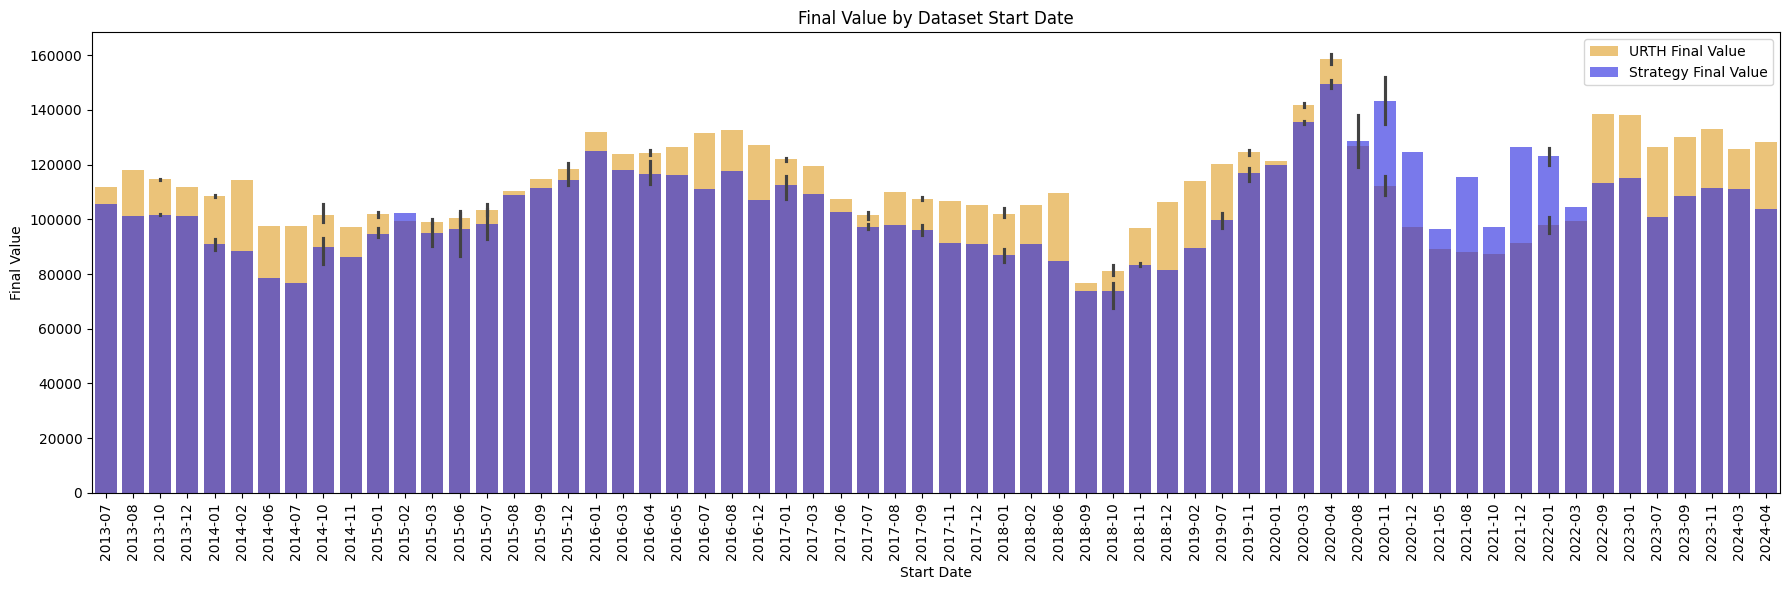

In [6]:
#plot final_value by start month
datasets_monthly_returns = datasets_stats.copy()[['Start Date', 'final_value','Index Final Value']]
datasets_monthly_returns.index = pd.to_datetime(datasets_monthly_returns['Start Date'])
datasets_monthly_returns = datasets_monthly_returns.drop(columns=['Start Date'])
datasets_monthly_returns = datasets_monthly_returns.sort_index()

plt.figure(figsize=(18, 6))
sns.barplot(x=datasets_monthly_returns.index.strftime('%Y-%m'), y=datasets_monthly_returns['Index Final Value'], color='orange', alpha=0.6, label=f'{index_name} Final Value')
sns.barplot(x=datasets_monthly_returns.index.strftime('%Y-%m'), y=datasets_monthly_returns['final_value'], color='blue', alpha=0.6, label='Strategy Final Value')
plt.xticks(rotation=90)
plt.title('Final Value by Dataset Start Date')
plt.xlabel('Start Date')
plt.ylabel('Final Value')
plt.tight_layout()
plt.show()


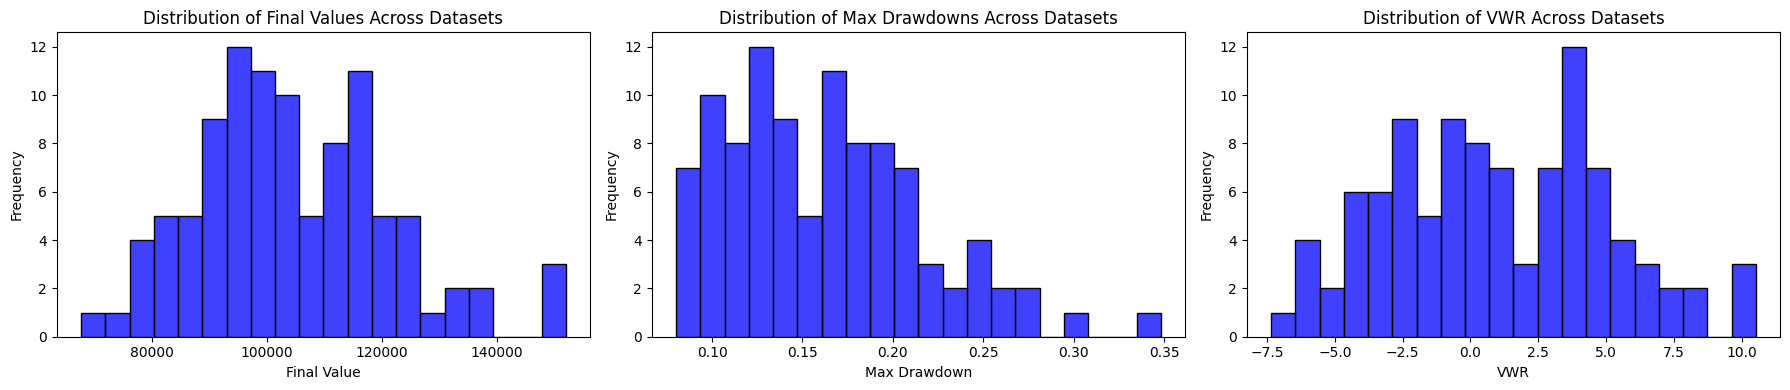

In [7]:
#plot three histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(datasets_stats['final_value'], bins=20, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Final Values Across Datasets')
axes[0].set_xlabel('Final Value')
axes[0].set_ylabel('Frequency')

sns.histplot(datasets_stats['max drawdown'], bins=20, color='blue', ax=axes[1])
axes[1].set_title('Distribution of Max Drawdowns Across Datasets')
axes[1].set_xlabel('Max Drawdown')
axes[1].set_ylabel('Frequency')

sns.histplot(datasets_stats['VWR'], bins=20, color='blue', ax=axes[2])
axes[2].set_title('Distribution of VWR Across Datasets')
axes[2].set_xlabel('VWR')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
top=0
bottom=3

In [11]:
# top and bottom datasets details

if top>0:
    top_stats = datasets_stats.sort_values(by=analyze_by, ascending=False).head(top)
    empty_cols = [col for col in top_stats.columns if top_stats[col].replace('', np.nan).isna().all()]
    top_stats = top_stats.drop(columns=empty_cols)

    display(Markdown(f"### Top {top} Datasets by {analyze_by}"))
    display(format_df(top_stats.T))

    with open(f"{strategy_images_path}/top_{top}_datasets_by_{analyze_by}.md", "w") as f:
        f.write(f"### Top {top} Datasets by {analyze_by}\n")
        f.write(format_df(top_stats.T).to_markdown())

# bottom datasets

if bottom>0:
    bottom_stats = datasets_stats.sort_values(by=analyze_by, ascending=False).tail(bottom)
    empty_cols = [col for col in bottom_stats.columns if bottom_stats[col].replace('', np.nan).isna().all()]
    bottom_stats = bottom_stats.drop(columns=empty_cols)

    display(Markdown(f"### Bottom {bottom} Datasets by {analyze_by}"))
    display(format_df(bottom_stats.T))

    with open(f"{strategy_images_path}/bottom_{bottom}_datasets_by_{analyze_by}.md", "w") as f:
        f.write(f"### Bottom {bottom} Datasets by {analyze_by}\n")
        f.write(format_df(bottom_stats.T).to_markdown())

#print top datasets stats returns and weights
strategy_returns = test_results.strategies[analyze_strategy].get_datasets_returns()
strategy_cum_returns = (1 + strategy_returns).cumprod()
datasets_weights = test_results.strategies[analyze_strategy].get_datasets_weights()
top_list = datasets_stats.sort_values(by=analyze_by, ascending=False).head(top).index.tolist()
bottom_list = datasets_stats.sort_values(by=analyze_by, ascending=False).tail(bottom).index.tolist()
datasets_top_and_bottom_list = top_list + bottom_list
datasets_data = test_results.get_datasets_data(datasets_filter_list=datasets_top_and_bottom_list,column="adjusted")

def calculate_index_returns(index_returns, start_date, end_date):
    # Filter index returns for the given date range
    filtered_returns = index_returns[(index_returns.index >= start_date) & (index_returns.index <= end_date)]
    # Calculate cumulative returns from log returns
    cum_returns = (1 + filtered_returns).cumprod()
    # Apply starting value
    returns_df = pd.DataFrame(index=filtered_returns.index)
    #returns_df['returns'] = filtered_returns
    returns_df['index'] =  cum_returns
    return returns_df


for dataset_name in datasets_top_and_bottom_list:
    dataset_df = pd.DataFrame(datasets_data.get(dataset_name))
    start_date = dataset_df.index.min()
    end_date = dataset_df.index.max()
    log_returns = np.log(dataset_df / dataset_df.shift(1))
    dataset_adjusted = np.exp(log_returns.cumsum())
    dataset_index_returns = calculate_index_returns(index_returns, start_date, end_date)
    fig = go.Figure()
    x_dates=dataset_adjusted.index
    # Plot each asset's cumulative return as a separate line
    for col in dataset_adjusted.columns:
        fig.add_trace(go.Scatter(
            x=x_dates,
            y=dataset_adjusted[col],
            mode='lines',
            name=col,
            line=dict(width=1),
            hovertemplate=f"{col}<br>Date: %{{x}}<br>Cumulative Return: %{{y:.4f}}<extra></extra>"
        ))
    fig.add_trace(go.Scatter(
        x=x_dates,
        y=strategy_cum_returns[dataset_name],
        mode='lines',
        name='Total',
        line=dict(color='black', width=2),
        hovertemplate="Total<br>Date: %{x}<br>Cumulative Return: %{y:.4f}<extra></extra>"
    ))
    fig.add_trace(go.Scatter(
        x=dataset_index_returns.index,
        y=dataset_index_returns['index'],
        mode='lines',
        name=f'{index_name} Index',
        line=dict(color='red', width=2),
        hovertemplate=f"{index_name} Index<br>Date: %{{x}}<br>Cumulative Return: %{{y:.4f}}<extra></extra>"
    ))
    fig.update_layout(
        title=f'Cumulative Returns for {dataset_name}',
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        height=600
    )
    
    pyoff.iplot(fig)
    """
    #display(Markdown(f"### Weights"))
    #wdf = datasets_weights.get(dataset_name)
    #if wdf is None or wdf.empty:
    #    display(Markdown("No weights available for this dataset."))
    #else:
        # ensure a color palette is available (use Plotly qualitative palette)
    
        colors = px.colors.qualitative.Plotly

        fig_w = go.Figure()
        cols = list(wdf.columns)
        ncols = len(cols)
        # build enough colors by repeating the palette
        color_cycle = list(np.tile(colors, int(np.ceil(ncols / len(colors)))))[:ncols]

        for i, col_name in enumerate(cols):
            fig_w.add_trace(go.Bar(
                x=wdf.index,
                y=wdf[col_name],
                name=col_name,
                marker_color=color_cycle[i],
                hovertemplate=f"{col_name}<br>Date: %{{x}}<br>Weight: %{{y:.6f}}<extra></extra>"
            ))

        fig_w.update_layout(
            barmode='stack',
            height=450,
            title=f'Stacked Portfolio Weights for {dataset_name}',
            xaxis_title='Date',
            yaxis=dict(title='Weight', range=[0, 1]),
            showlegend=True
        )
    
    pyoff.iplot(fig_w)
    """
    portfolio_data = test_results.strategies[analyze_strategy].datasets[dataset_name].get_asset_values('portfolio')
    portfolio_value_history = portfolio_data['portfolio_value']

    # Plot stacked bar chart of asset values
    asset_value_history = pd.DataFrame(test_results.strategies[analyze_strategy].datasets[dataset_name].get_asset_values('values'))
    asset_value_history['Cash'] = portfolio_data['cash']
    display(Markdown("### Asset Values Over Time"))
    # Use the same color palette as weights chart
    colors = px.colors.qualitative.Plotly

    fig_av = go.Figure()
    cols = list(asset_value_history.columns)
    ncols = len(cols)
    color_cycle = list(np.tile(colors, int(np.ceil(ncols / len(colors)))))[:ncols]

    for i, col_name in enumerate(cols):
        fig_av.add_trace(go.Bar(
            x=asset_value_history.index,
            y=asset_value_history[col_name],
            name=col_name,
            marker_color=color_cycle[i],
            hovertemplate=f"{col_name}<br>Date: %{{x}}<br>Value: %{{y:.2f}}<extra></extra>"
        ))

    fig_av.update_layout(
        barmode='stack',
        height=450,
        title=f'Stacked Asset Values for {dataset_name}',
        xaxis_title='Date',
        yaxis_title='Asset Value ($)',
        showlegend=True
    )

    pyoff.iplot(fig_av)

### Bottom 3 Datasets by VWR

,dataset_37,dataset_33,dataset_73
Sharpe ratio,-1.53,-2.06,-3.28
max drawdown,0.24,0.30,0.35
annual return,-0.12,-0.14,-0.18
annual volatility,0.09,0.11,0.10
VWR,-5.79,-6.35,-7.35
VaR (5%),-0.01,-0.01,-0.01
skewness,-0.98,-1.05,-1.31
kurtosis,3.86,4.45,5.21
Sortino ratio,-1.51,-1.33,-1.67
final_value,"76,616.45","73,638.59","67,684.18"


### Asset Values Over Time

### Asset Values Over Time

### Asset Values Over Time